## 使用Fashion Minst数据集进行服装分类
在此次样例中，将建立神经网络对服装图片进行分类。一共十类，分别为：
> class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 输入
28 * 28黑白图片
### 输出
数字0-9表示类别

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf

# Helper libraries
import math
import gzip
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)

2.0.0-beta0


## 加载数据
由于使用tensorflow_datasets加载Fashion Mnist数据集时，会因为网络原因导致无法加载，因此将数据下载到本地。

数据下载地址：<a href='https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion'>https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion</a>

使用gzip进行文件读取操作

In [2]:
def load_data():
    base = "./fashion mnist data/"
    files = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]


    with gzip.open(base + files[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(base + files[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(base + files[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(base + files[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

    return (x_train, y_train), (x_test, y_test)

60000 10000


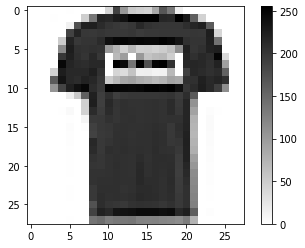

T-shirt/top


In [3]:
# 读取数据
(train_images, train_labels), (test_images, test_labels) = load_data()

# 定义不同类别的名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 获取训练集以及测试集中样本的数量
TRAINING_SAMPLE_NUM = train_images.shape[0]
TEST_SAMPLE_NUM = test_images.shape[0]
print(TRAINING_SAMPLE_NUM, TEST_SAMPLE_NUM)

# 取出一张图片进行展示
plt.figure()
plt.imshow(train_images[1], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()
print(class_names[train_labels[1]])

将数据变为``tf.data.Dataset``的形式

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

将图片数据的像素值从0-255变为0-1的浮点数

In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

## 构建模型
* **input layer** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.
* **hidden layer** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.
* **output layer** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

## 编译模型
* ``loss``这里使用了``tf.keras.losses.sparse_categorical_crossentropy``作为损失函数。``tf.keras.losses.sparse_categorical_crossentropy``与``tf.keras.losses.categorical_crossentropy``的区别为：
    * ``tf.keras.losses.categorical_crossentropy``的``y_true``为``one-hot``编码形式。TensorFlow官方文档中对``tf.keras.losses.CategoricalCrossentropy``类的描述为
    > Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a ``one_hot`` representation. If you want to provide labels as integers, please use ``SparseCategoricalCrossentropy`` loss. There should be ``# classes`` floating point values per feature.
    * ``tf.keras.losses.sparse_categorical_crossentropy``的``y_true``为数字形式。TensorFlow官方文档中对``tf.keras.losses.SparseCategoricalCrossentropy``类的描述为
    > Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using ``one-hot`` representation, please use ``CategoricalCrossentropy`` loss. There should be ``# classes`` floating point values per feature for ``y_pred`` and a single floating point value per feature for ``y_true``.
* ``optimizer``这里依然选择使用效果最好的``Adam``优化方法
* ``metrics``这里传入的参数为``[accuracy]``，会自动选择合适的方法进行效果评估。适合此样例的评估方法为``tf.keras.metrics.sparse_categorical_accuracy``。``tf.keras.metrics.Accuracy()``、``tf.keras.metrics.categorical_accuracy``、``tf.keras.metrics.sparse_categorical_accuracy``三者的区别为：
    * ``tf.keras.metrics.Accuracy()``的``y_true``和``y_pred``均是数字，如：``y_true`` is [1, 2, 3, 4] and ``y_pred`` is [0, 2, 3, 4]
    * ``tf.keras.metrics.categorical_accuracy``的``y_true``是``one-hot``，而``y_pred``是维度与类别数相同的一维数组，如：``y_true`` is [[0, 0, 1], [0, 1, 0]] and ``y_pred`` is [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]
    * ``tf.keras.metrics.sparse_categorical_accuracy``的``y_true``是数字，而``y_pred``是维度与类别数相同的一维数组，如：``y_true`` is [[2], [1]] and ``y_pred`` is [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]

In [9]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(0.01),
             metrics=['accuracy'])

'''
tf.keras.metrics.Accuracy()
tf.keras.metrics.categorical_accuracy
tf.keras.metrics.sparse_categorical_accuracy
'''

'\ntf.keras.metrics.Accuracy()\ntf.keras.metrics.categorical_accuracy\ntf.keras.metrics.sparse_categorical_accuracy\n'

## 训练模型

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(TRAINING_SAMPLE_NUM).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(TRAINING_SAMPLE_NUM / BATCH_SIZE), verbose=1)

Epoch 1/5


W0723 15:35:24.799915  5528 deprecation.py:323] From C:\Users\arsener\PycharmProjects\tensorflow2.0beta\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1875/1875 [==============================] - 14s 8ms/step - loss: 0.5163 - accuracy: 0.8176
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4430 - accuracy: 0.8396
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4109 - accuracy: 0.8509
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4040 - accuracy: 0.8550
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3899 - accuracy: 0.8592


## 评估模型

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(TEST_SAMPLE_NUM / BATCH_SIZE))
print('Loss and accuracy on test dataset: {0:.4f}, {1:.4f}'.format(test_loss, test_accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 0.4647 - accuracy: 0.8405
Loss and accuracy on test dataset: 0.4647, 0.8405
